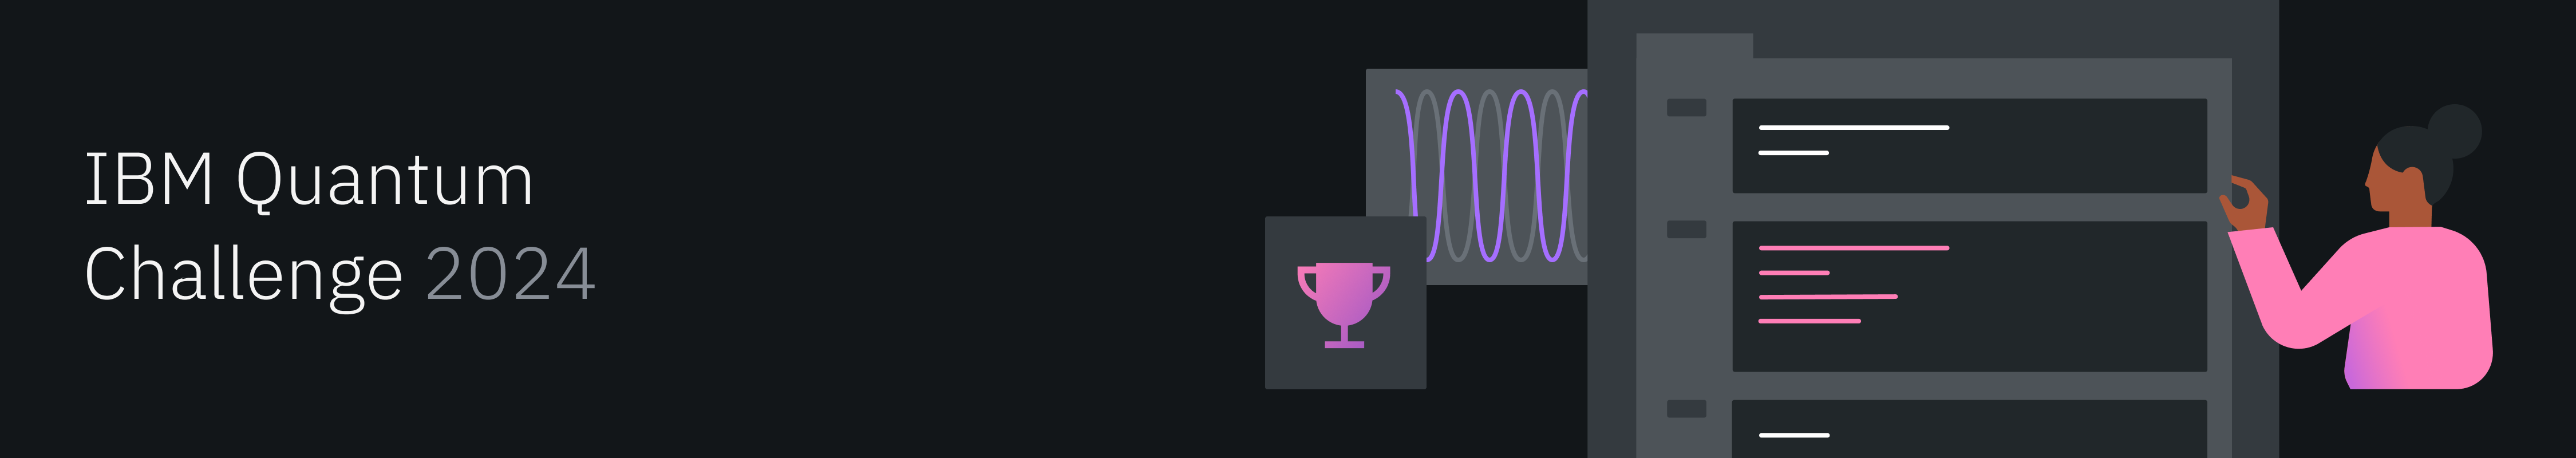

# Lab 4: Testing a Variational Quantum Classifier on a real backend


In this lab, you will learn how to build and train a simple Variational Quantum Classifier (VQC) on an ideal backend using the Qiskit Patterns workflow. Once the VQC is trained, you will experience how the presence of noise has an impact on its performance. Finally, you will learn how to reduce the depth of the VQC and then run the resulting circuit on quantum hardware to see how error suppression and error mitigation techniques have an impact on the results.


## Table of Contents

* [Part 1: Design a VQC on an ideal backend](#part-1-design-a-VQC-on-an-ideal-backend)
    * [Exercise 1](#exercise1)
    * [Exercise 2](#exercise2)
    * [Exercise 3](#exercise3)
* [Part 2: Impact of noise on the performance of the VQC](#part-2-impact-of-noise-on-the-performance-of-the-VQC)
    * [Exercise 4](#exercise4)
* [Part 3: Test the VQC on quantum hardware](#part-3-test-the-VQC-on-quantum-hardware)
    * [Exercise 5](#exercise5)
    * [Exercise 6](#exercise6)
    * [Exercise 7](#exercise7)

Let's start by importing all the libraries that will be needed in this Lab:

# Imports

In [ ]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install qiskit[visualization]==1.0.2
%pip install qiskit-ibm-runtime
%pip install qiskit-aer
%pip install graphviz
%pip install qiskit-serverless -U
%pip install qiskit-transpiler-service -U
%pip install git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

Now, let's run our imports and setup the grader

In [ ]:
# Import all in one cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import InstructionProperties
from qiskit.visualization import plot_distribution
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.primitives import StatevectorEstimator

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    QiskitRuntimeService, 
    EstimatorV2 as Estimator,
    SamplerV2 as Sampler,
    EstimatorOptions
)

In [ ]:
### Save API Token, if needed

%set_env QXToken=deleteThisAndPasteYourTokenHere

# Set Grade only mode
%set_env QC_GRADE_ONLY=true

# Make sure there is no space between the equal sign
# and the beginning of your token

In [ ]:
# qc-grader should be 0.18.12 (or higher)
import qc_grader

qc_grader.__version__

In [ ]:
from qc_grader.challenges.iqc_2024 import (
    grade_lab4_ex1,
    grade_lab4_ex2,
    grade_lab4_ex3,
    grade_lab4_ex4,
    grade_lab4_ex5,
    grade_lab4_ex6,
    grade_lab4_ex7
)

## Part 1: Design a VQC on an ideal backend

Variational quantum classifiers (VQCs) are a type of variational quantum algorithm that can solve certain types of classification problems. In particular, VQCs feature a hybrid architecture. This architecture is based on an ansatz in the form of a parametrized quantum circuit applied onto an initial state. The output is measured in the form of a cost function, which is classically optimized over the circuit's parameters until we converge to a minimum.

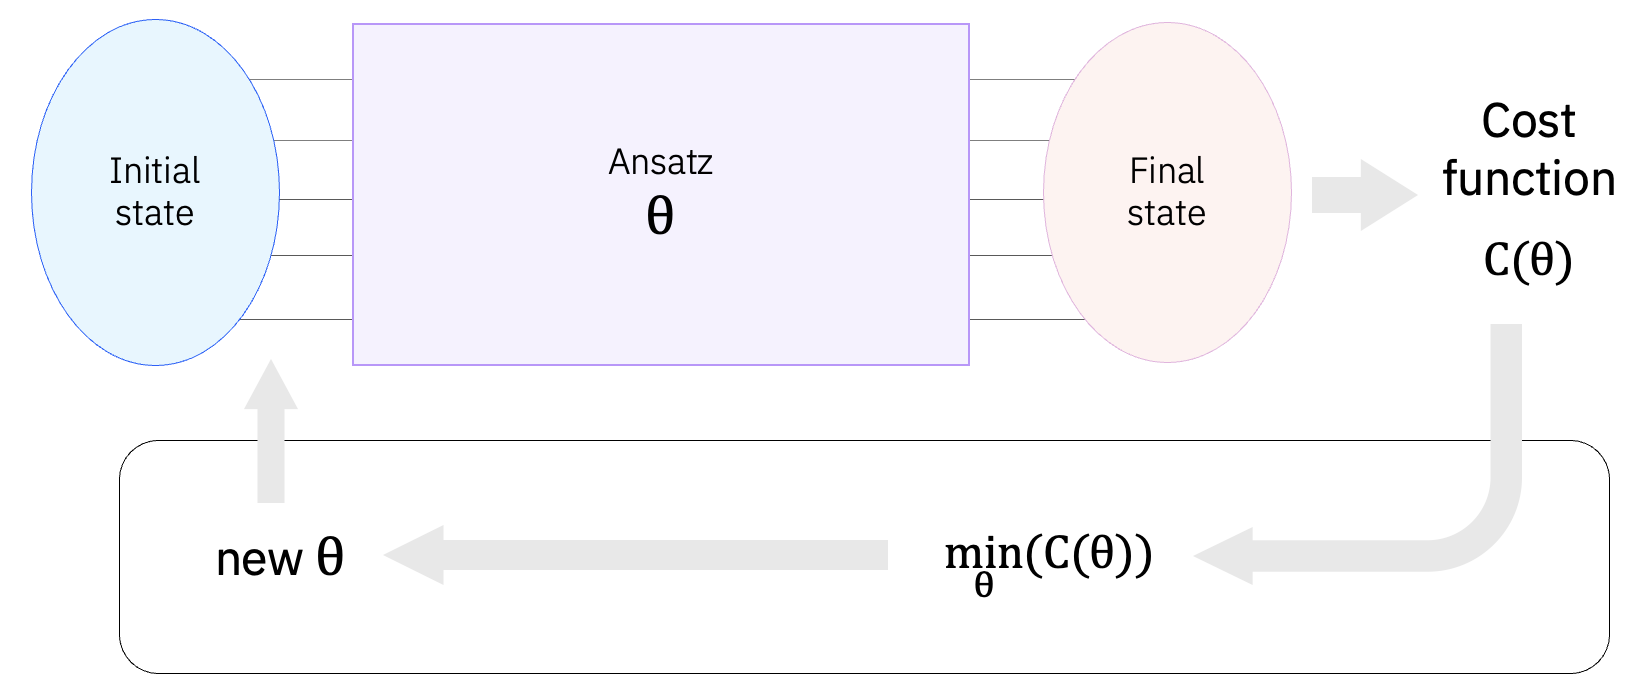

In this Lab, you are given a list of 10 birds:

 > Falcon, Hummingbird, Eagle, Osprey, Heron, Peacock, Parrot, Swan, Toucan, Cardinal.

The first five birds in the list are IBM Quantum birds, since processor types were named after them - check them out [here](https://docs.quantum.ibm.com/run/processor-types). The rest of them are non-IBM Quantum birds.

The dataset is given to you in the form of a dictionary, *bird_dataset.csv*. Each bird corresponds to an entry, and it is associated with a 5-qubit quantum state given in a _statevector_ form. Therefore, for each bird you will find $2^5 = 32$ coefficients.

For this problem, IBM Quantum birds are associated with entangled quantum states, while non-IBM quantum birds are associated to non-entangled (product) quantum states. Turns out that distinguishing between entangled and non-entangled quantum states is not an easy problem in general! The goal of this part of the Lab is to build a VQC that is able to distinguish the two sets of birds. 

But do not worry! We will guide you through all the steps of the algorithm using a workflow based on [Qiskit Patterns](https://www.ibm.com/quantum/blog/qiskit-patterns)**.

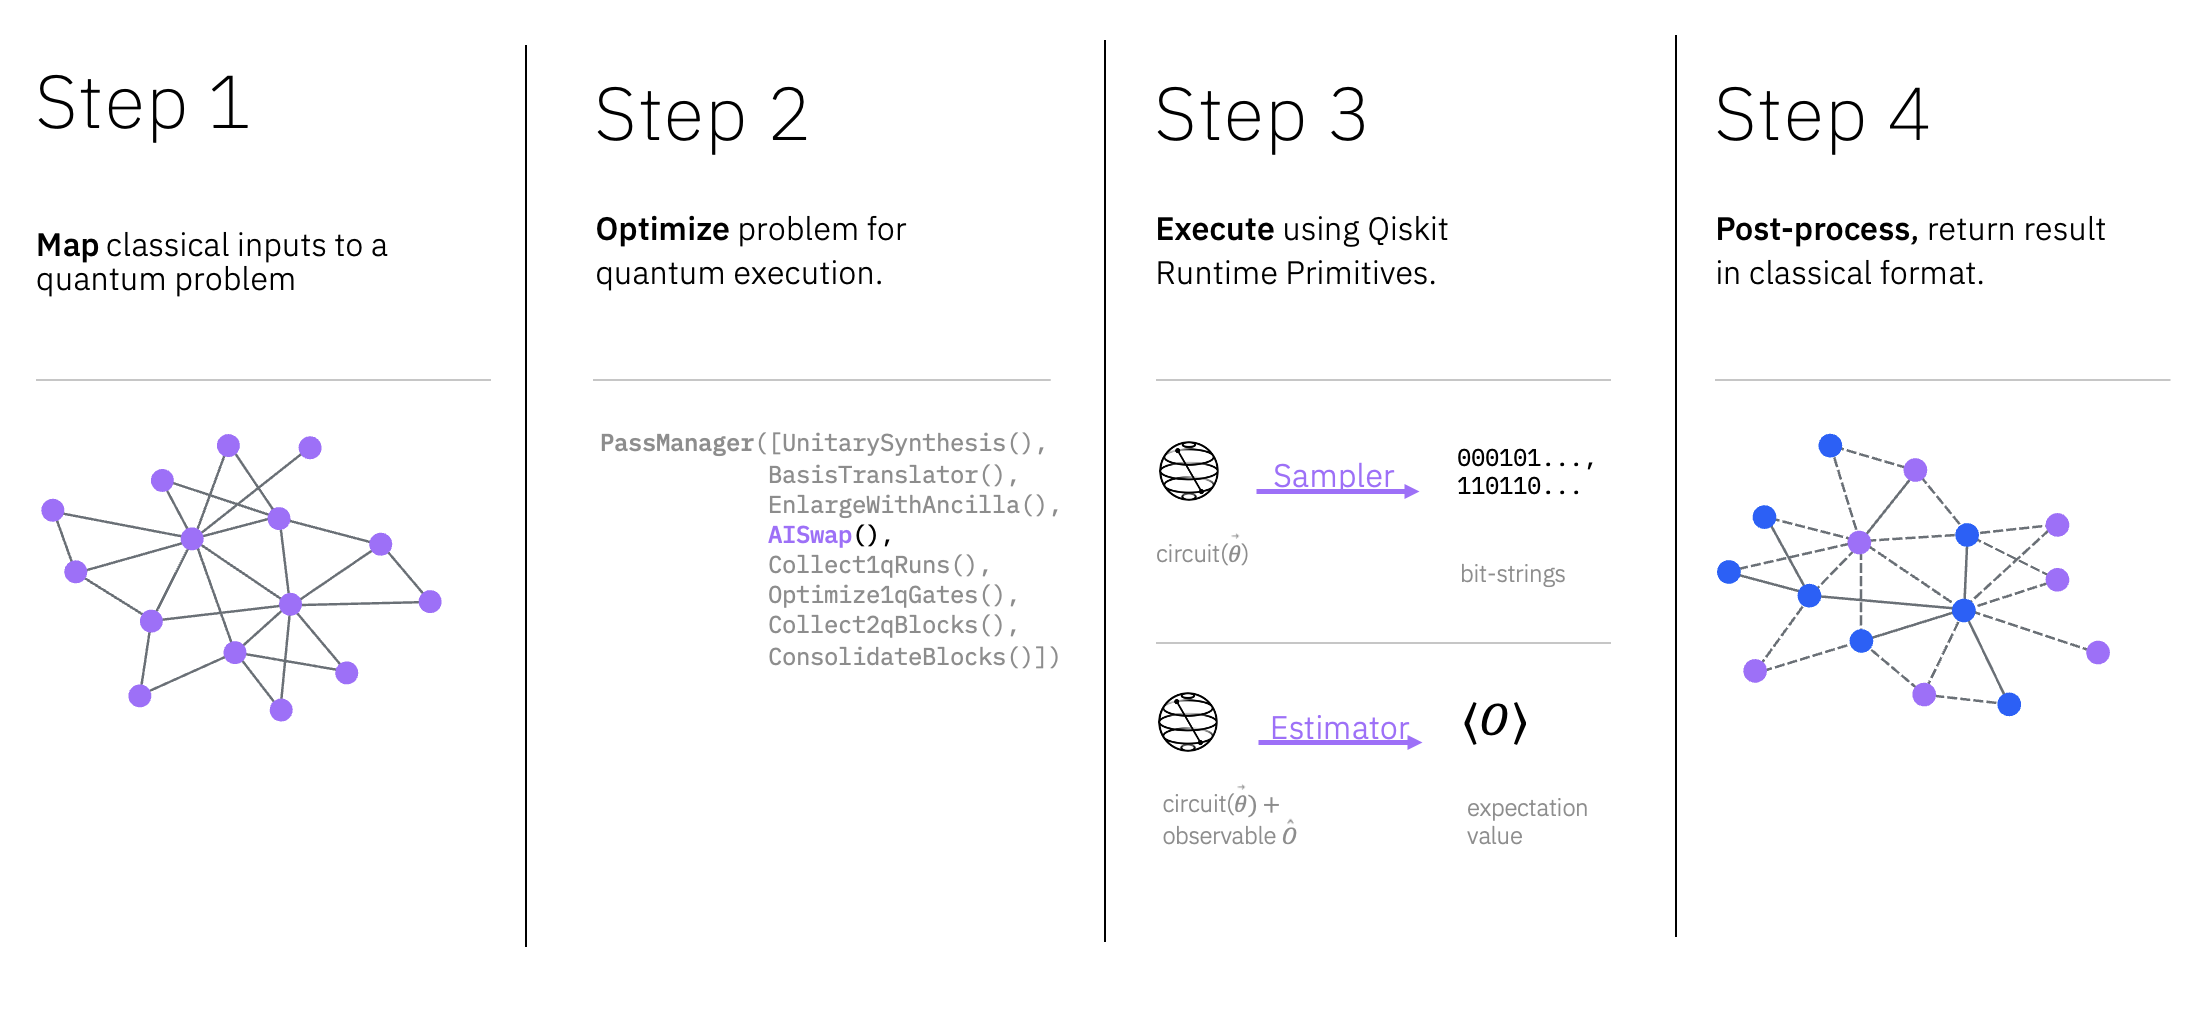

** Note that Qiskit Patterns represent a general workflow that can be applied to any type of problem, not only variational quantum algorithms!

### Step 1: Map classical inputs to a quantum problem

In this step of Qiskit Patterns, we are interested in translating a problem into a quantum circuit and a set of measurements that can reasonably run on quantum hardware. Note that this is in general a hard problem, so here's a list of things to take into account:

- We want to choose problems that are classically hard. Distinguishing between entangled and non-entangled states is a classically hard problem, even though we are choosing a small-scale problem for our learning purposes.
- We need to translate the outcomes into an expectation value or a _cost function_. A _cost function_ is a problem-specific function that defines the problem's outcome as something to be minimized or maximized, and it is typically used for variational quantum algorithms with various applications in chemistry, machine learning, finance, optimization, etc.
- When possible, we should keep in mind the limitations and advantages of the hardware that we are going to use. In particular, the backend's connectivity is important: we want to map the problem to a circuit that is as close as possible to the IBM Quantum processors’ heavy-hex topology to avoid having to implement a lot of SWAP gates.

For now, let's first retrieve the classical data, which in this case are the _statevector_ coefficients for each of the birds.

<div class="alert alert-block alert-danger">

**Please note:** This notebook needs additional scripts located in the same [folder](https://github.com/qiskit-community/ibm-quantum-challenge-2024/tree/main/content/lab_4). Ensure you transfer and store these files in the same directory as the notebook in your environment. **The files that are required are:**  `birds_dataset.csv`, `params_0_list.npy` and `opt_params_shallow_VQC.npy`.

</div>

In [ ]:
# Define num_qubits, the number of qubits, for the rest of the Lab
num_qubits = 5

# Load the dictionary 
birds_dataset = pd.read_csv('birds_dataset.csv') 

# Check if the dataset is loaded correctly - coefficients should be complex numbers
for i in range(2**num_qubits):
    key = 'c%.0f' %i
    birds_dataset[key] = birds_dataset[key].astype(np.complex128)

# Print the dataset
birds_dataset

<a id="exercise1"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 1:</b> 

Retrieve the coefficients of each of the quantum states from the dictionary. Save them in a list of lists containing complex numbers: ```[[], [], [], ...]```. Create a corresponding list of labels with label 1 for IBM Quantum birds and label 0 for non-IBM Quantum birds: ```[int, int, ...]```.
    
</div>

In [ ]:
### Write your code below here ###
list_coefficients = []
list_labels = []
for i in range(10):
    amplitude_state = []
    if i < 5:
        list_labels.append(1)
    else:
        list_labels.append(0)
    for j in range(2**num_qubits):
        key = 'c%.0f' %j
        amplitude_state.append(birds_dataset[key][i])
    list_coefficients.append(amplitude_state)
### Don't change any code past this line ###    

In [ ]:
# Submit your answer using following code 
grade_lab4_ex1(list_coefficients, list_labels)

Now that the data is ready, we want to map it onto the quantum circuit. In this case, we are going to use the **amplitude embedding** technique, which can be easily implemented in Qiskit via [initialization](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.Initialize). Since each of our $32$ coefficients corresponds to the amplitude of one of the basis states of a 5-qubit Hilbert space, the amplitude embedding is a straightforward mapping for this kind of dataset. As we will see later, `qc.initialize` is a general function that can map any quantum state. However, this function can lead to very deep circuits. Given that we don't yet have full information on the dataset, we will use this mapping approach for now.

For more general classification problems, we can consider other mappings. The choice of the mapping should depend on the structure of the dataset that we are given. In general, the data is mapped onto the parameters of a set of parametrized quantum gates. A typical example is the [ZZ Feature Map](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.ZZFeatureMap).

Let's build the amplitude embedding circuit and take a look at it:

In [ ]:
index_bird = 2 # You can check different birds by changing the index
amplitudes = list_coefficients[index_bird]

# Build the amplitude embedding 
qc = QuantumCircuit(5)
qc.initialize(amplitudes, range(num_qubits))
qc.measure_all()

# Draw the amplitude embedding circuit
qc.draw(output="mpl")

If we decompose the circuit before drawing it, we can better see its structure. As mentioned above, the ```qc.initialize()```function leads to a very deep circuit. In fact, the problem of state preparation, which aims at mapping an arbitrary quantum state onto a quantum circuit efficiently, is still an open research problem.

In [ ]:
# Draw the decomposition of the amplitude embedding circuit
qc.decompose(reps=8).draw(output="mpl", fold=40)

Once the initial state is prepared, we need to build a variational ansatz for the VQC. The ansatz typically consists of a collection of parametrized rotation gates and entangling layers that are repeated a given number of times. By tuning the parameters of the rotations, we can explore a specific area of the Hilbert space. 

Choosing the right ansatz that allows us to converge to the desired solution is not an easy problem. In general, there are a few trade-offs to consider:

- **Speed**: By reducing the search space, and thus the number of gates and the depth of the ansatz, the algorithm can run faster.
- **Accuracy**: Reducing the search space could risk excluding the actual solution to the problem, leading to suboptimal solutions.
- **Noise**: Deeper circuits are affected by noise, so we need to experiment with our ansatz's connectivity, gates, and gate fidelity.

> If you want to know more about how to design the ansatz for your variational quantum circuits, we strongly recommend the [Variational algorithm design](https://learning.quantum.ibm.com/course/variational-algorithm-design) course in the IBM Learning Platform. 

By checking the [Qiskit circuit library](https://docs.quantum.ibm.com/api/qiskit/circuit_library#n-local-circuits) you will see that there are many architectures to build an ansatz, such as the [`TwoLocal`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal), the [`EfficientSU2`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.EfficientSU2) and the [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) ansatzes. For this exercise, we choose the [`RealAmplitudes`](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.RealAmplitudes) ansatz.

<a id="exercise2"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 2:</b> 

Build the ansatz using the ```RealAmplitudes``` circuit from the Qiskit circuit library. The ansatz should look as follows:

</div>

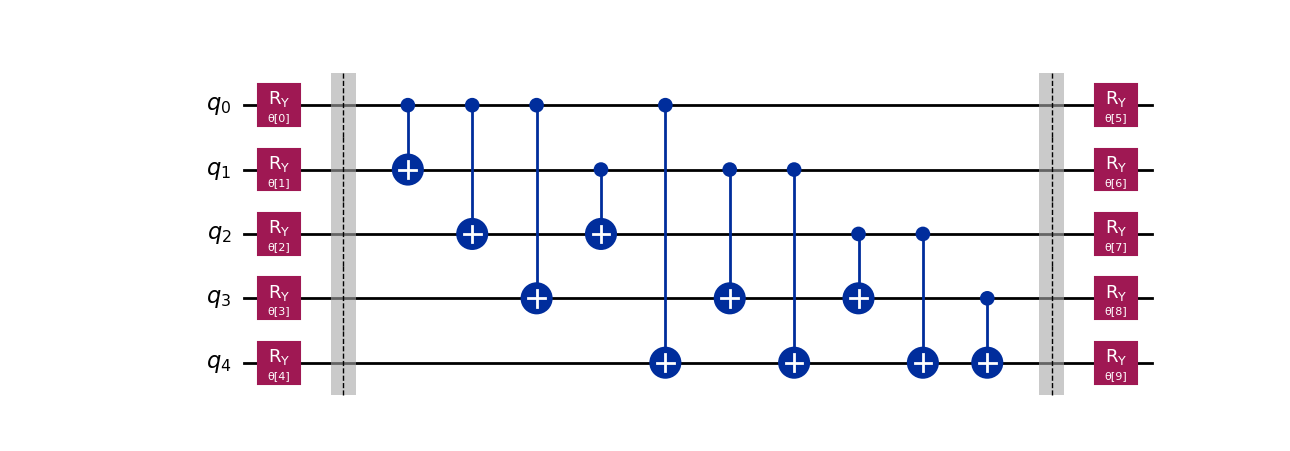

In [ ]:
### Write your code below here ###
num_qubits = 5
reps = 1
entanglement = 'full'
ansatz = RealAmplitudes(num_qubits, reps=reps, entanglement=entanglement, insert_barriers=True)
ansatz.decompose(reps=1).draw(output="mpl")
### Don't change any code past this line ###    

In [ ]:
# Submit your answer using following code
grade_lab4_ex2(num_qubits, reps, entanglement)

### Steps 2 & 3: Optimize the problem for quantum execution and execute it using Qiskit primitives

Step 2 of Qiskit Patterns, which was introduced in Lab 2, deals with the transpilation process to efficiently map our circuit onto the quantum hardware. Then, Step 3 deals with the execution of the final circuit using the Qiskit primitives. In this case, we are going to use the Estimator primitive to build the cost function of our VQC.

- [Transpilation](https://docs.quantum.ibm.com/transpile) includes mapping each logical qubit of the circuit to an actual physical qubit in the device and then translating the individual quantum gates into sequences of operations that are performed on the quantum hardware. In certain cases, SWAP gates need to be added in order to adapt to the topology of the devices, which follow a [heavy-hex pattern](https://www.ibm.com/quantum/blog/heavy-hex-lattice). 

- The [Estimator primitive](https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.EstimatorV2) uses a complex algebraic process to estimate the expectation value on a real quantum device, by breaking down the observable into a combination of other observables with known eigenbases.

The cost function is defined in terms of the expectation value of an observable $\hat{O}$ on the outputs of the circuit for each of the birds in the dataset:

$C(\theta) = \sum_{i\in \text{birds}} (\langle \psi_i(\theta) \vert \hat{O} \vert \psi_i(\theta) \rangle - L_i),$

where $\psi_i(\theta)$ is the output state of the circuit for the bird $i$ and $L_i$ is the label for the same bird. The observable is $\hat{O} = ZZZZZ$ and $\theta$ is the vector of parameters for the ansatz.

If we successfully train the VQC, which means that we reach the optimal set of parameters $\theta^{opt}$ that minimizes the cost function, the VQC will output an expectation value of $\langle ZZZZZ \rangle = 1$ for IBM Quantum birds and $\langle ZZZZZ \rangle = 0$ for non-IBM Quantum birds.

In [ ]:
# Define the observable 
obs = SparsePauliOp("ZZZZZ")

In [ ]:
# Define the estimator and pass manager
estimator = StatevectorEstimator() #To train we use StatevectorEstimator to get the exact simulation
pm = generate_preset_pass_manager(backend=AerSimulator(), optimization_level=3, seed_transpiler=0) 

In [ ]:
# Define the cost function
def cost_func(params, list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict):

    """Return cost function for optimization

    Parameters:
        params (ndarray): Array of ansatz parameters
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        estimator (EstimatorV2): Statevector estimator primitive instance
        pm (PassManager): Pass manager
        callback_dict (dict): Dictionary to store callback information

    Returns:
        float: Cost function estimate
    """

    cost = 0
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        # Amplitude embedding
        qc.initialize(amplitudes)
        # Compose initial state + ansatz
        classifier = qc.compose(ansatz) 
        # Transpile classifier
        transpiled_classifier = pm.run(classifier)
        # Transpile observable
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        # Run estimator
        pub = (transpiled_classifier, transpiled_obs, params)
        job = estimator.run([pub])
        # Get result
        result = job.result()[0].data.evs
        # Compute cost function (cumulative)
        cost += np.abs(result - label)

    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = params
    callback_dict["cost_history"].append(cost)

    # Print the iterations to screen on a single line
    print(
        "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], cost),
        end="\r",
        flush=True,
    )
    
    return cost

### Step 4: Classical post-processing stage

The last step of Qiskit Patterns includes any classical post-processing that we might run on the results. For the case of variational quantum algorithms, this stage includes the classical optimization of the ansatz parameters in order to minimize the cost function we have defined previously. This is the part in which we **TRAIN** the VQC.

To start the training, we need to define an initial set of parameters. Choosing this initial point is a very important step! A bad initial point can lead to severe complications in the training process. In particular, if the optimizer gets stuck in local minima we cannot converge to the optimal solution. 

Here, we will use five pre-saved configurations of initial parameters for the VQC, which can be found in `params_0_list.npy`.

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> Training can take around 2 minutes!
    
</div>

In [ ]:
# Intialize the lists to store the results from different runs
cost_history_list = []
res_list = []

# Retrieve the initial parameters
params_0_list = np.load("params_0_list.npy")

for it, params_0 in enumerate(params_0_list):

    print('Iteration number: ', it)
    
    # Initialize a callback dictionary
    callback_dict = {
        "prev_vector": None,
        "iters": 0,
        "cost_history": [],
    }

    # Minimize the cost function using scipy
    res = minimize(
        cost_func, 
        params_0, 
        args=(list_coefficients, list_labels, ansatz, obs, estimator, pm, callback_dict), 
        method="cobyla", # Classical optimizer
        options={'maxiter': 200}) # Maximum number of iterations
    
    # Print the results after convergence
    print(res)

    # Save the results from different runs
    res_list.append(res)
    cost_history_list.append(callback_dict["cost_history"])

<a id="optional"></a>
<div class="alert alert-block alert-info">
    
<b> Optional:</b> Save the list of optimized parameters and plot the cost convergence history for each of the initial points.
    
</div>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost history')
ax.set_ylabel('Cost')
ax.set_xlabel('Iterations')
### Write your code below here ###
#np.save('res_list.npy', res_list)

for it, cost_history in enumerate(cost_history_list):
    ax.plot(cost_history, label='Trial '+str(it))
    ax.legend()
### Don't change any code past this line ###    

<a id="exercise3"></a>
<div class="alert alert-block alert-success">

    
<b> Exercise 3:</b> 

In this exercise, you need to check which set of initial parameters yield the best convergence. For this, you need to define two functions that will be used throughout the Lab:

1. A function ```test_VQC```, which applies the circuit with optimal parameters to each of the birds in the data set and outputs the converged value of the cost function.
2. A function ```compute performance``` which outputs the total performance (P) for each set of optimal parameters, which is defined as 

$P = 100 - 100\cdot\sum_{i\in \text{birds}} \frac{\vert (\langle \psi_i(\theta_{opt}) \vert \hat{O} \vert \psi_i(\theta_{opt})\rangle - L_i\vert}{2^5}$.
 
</div>  

In [ ]:
def test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_coefficients (list): List of arrays of complex coefficients
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        list: List of test results
    """
    ### Write your code below here ###
    results_test = []
    for amplitudes,label in zip(list_coefficients, list_labels):
        qc = QuantumCircuit(num_qubits)
        qc.initialize(amplitudes)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        pub = (transpiled_classifier, obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(abs(result))
    ### Don't change any code past this line ###                                 
    return results_test

In [ ]:
def compute_performance(result_list, list_labels):
    
    """Return the performance of the classifier

    Parameters:
        result_list (list): List of results
        list_labels (list): List of labels
        
    Returns:
        float: Performance of the classifier
    """
    ### Write your code below here ###
    performance = 100
    for result, label in zip(result_list, list_labels):
        performance -= np.abs(abs(result) - label)/len(list_coefficients)*100
    ### Don't change any code past this line ###                                    
    return performance

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

for index in range(len(res_list)):
    opt_params = res_list[index].x
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)
    print(f"Performance for trial {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions trial '+str(index))

ax.legend()

In [ ]:
# Submit your answer using following code
best_result_index = 4 # Choose the index with the best result
grade_lab4_ex3(res_list[best_result_index]) # Expected result type: OptimizeResult

## Part 2: Impact of noise on the performance of the VQC

Now that our VQC is trained, we want to test whether it is still able to distinguish the two sets of birds when we add noise in a controlled manner. In this part of the Lab, we focus on local testing, meaning that we are going to simulate quantum noise on our local machine. For this reason, we will create a custom fake backend. But first, let’s talk a bit about different types of quantum noise:

1. **Decoherence**: Qubits will lose their information of the quantum state over time, especially if they stay idle after they are initialized. For decoherence we normally don't use an error rate, but instead use T1 and T2 time, the amount of time it takes until a qubit loses its information.
2. **Measurement Errors**: Measuring qubits can cause errors, meaning that instead of a 0, a 1 is measured, and vice versa. This works similar to a classical channel.
3. **Gate Errors**: Gates are not perfect and have a small chance to introduce an error when applied. This is especially true for two-qubit gates, like the CX, the CZ, or the ECR gate, which normally have roughly a 10x higher error rate than single-qubit gates.
4. **Crosstalk Errors**: When applying a gate to a qubit, other qubits, especially neighboring ones, can also be influenced. This is even the case if these qubits lie idle. Fortunately, on the newest Heron devices, this is less of a problem, but it is still something to be aware of.

We can see the coherence times as well as the error rates of quantum devices directly on the [IBM Quantum systems page](https://quantum.ibm.com/services/resources) when inspecting a device. Here is a short overview:

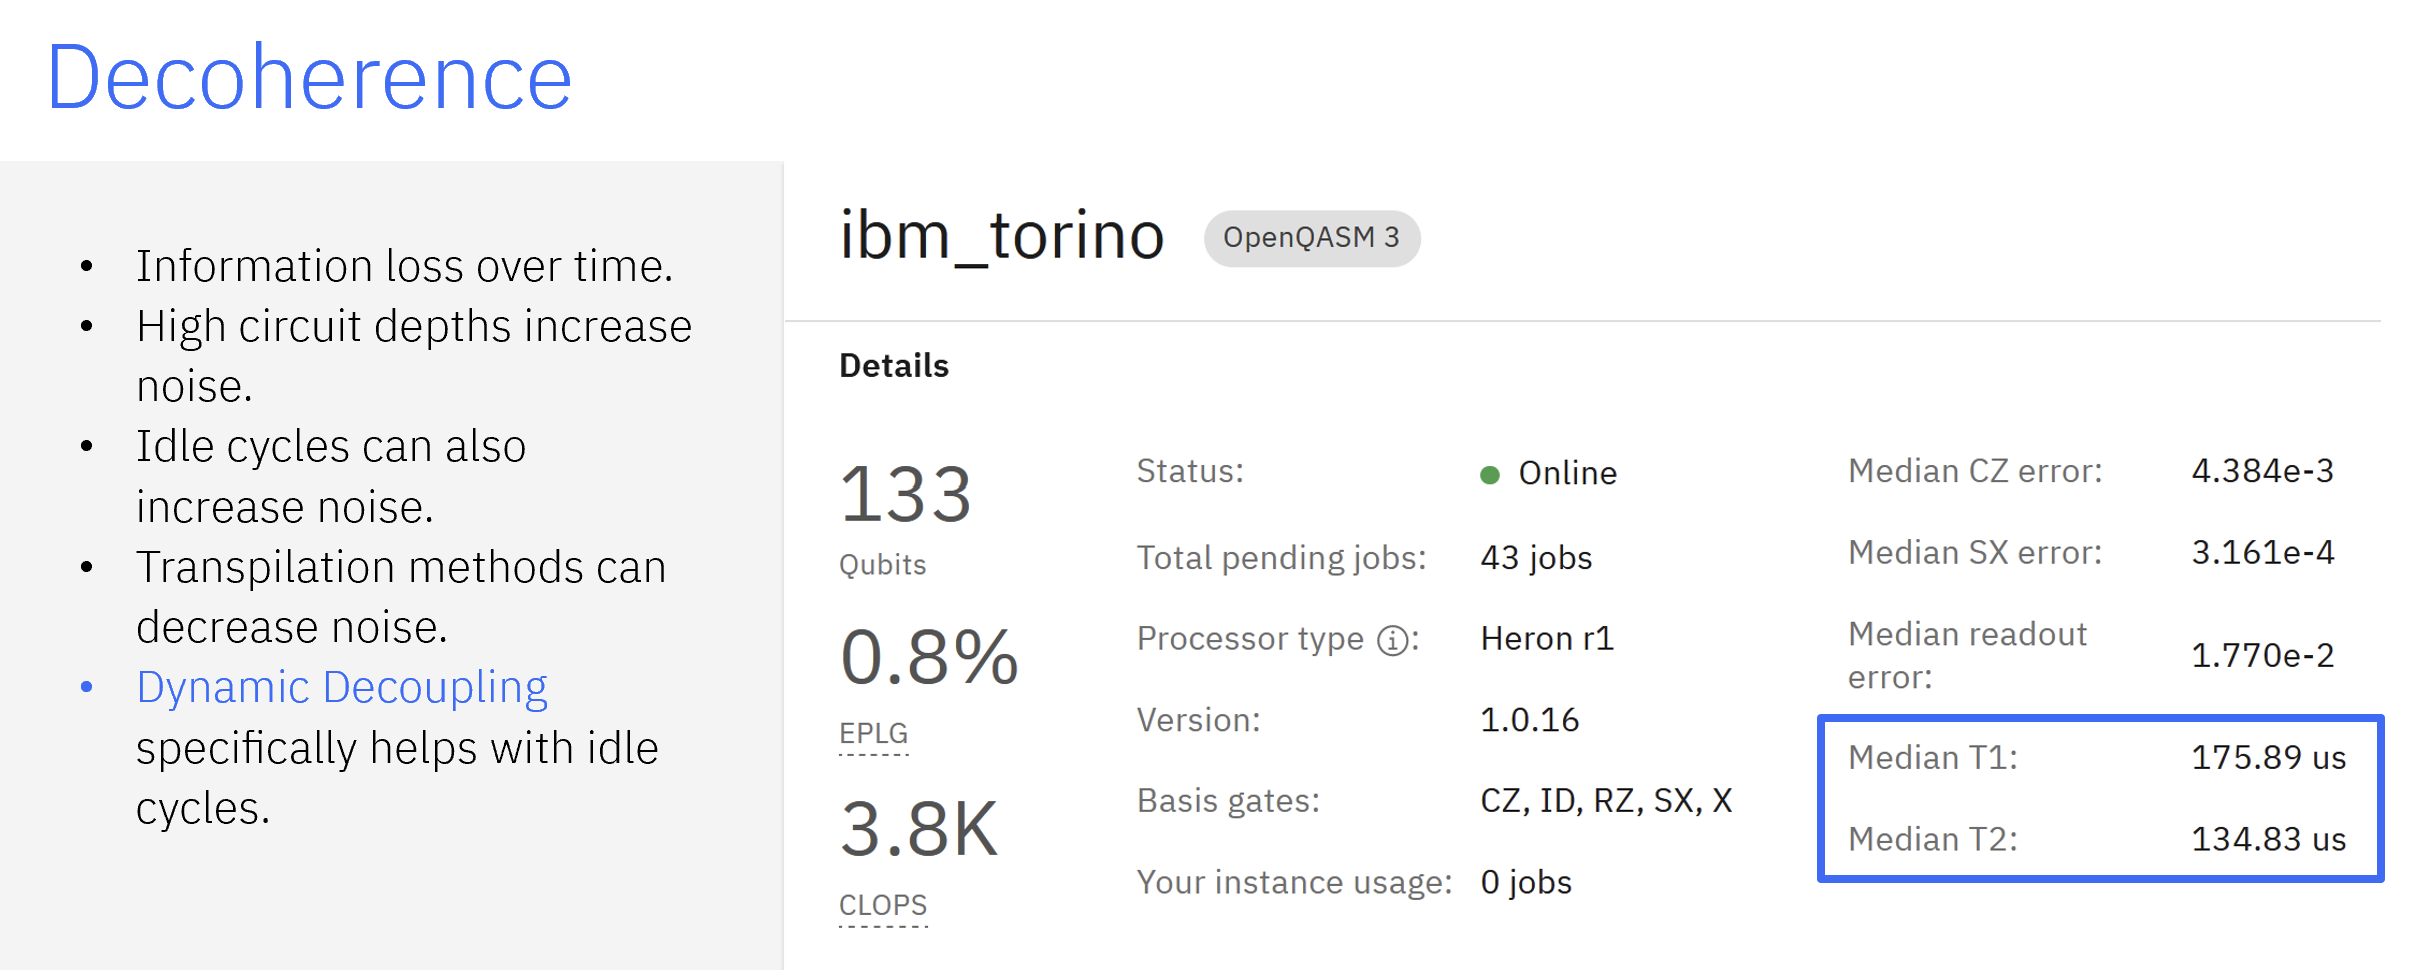

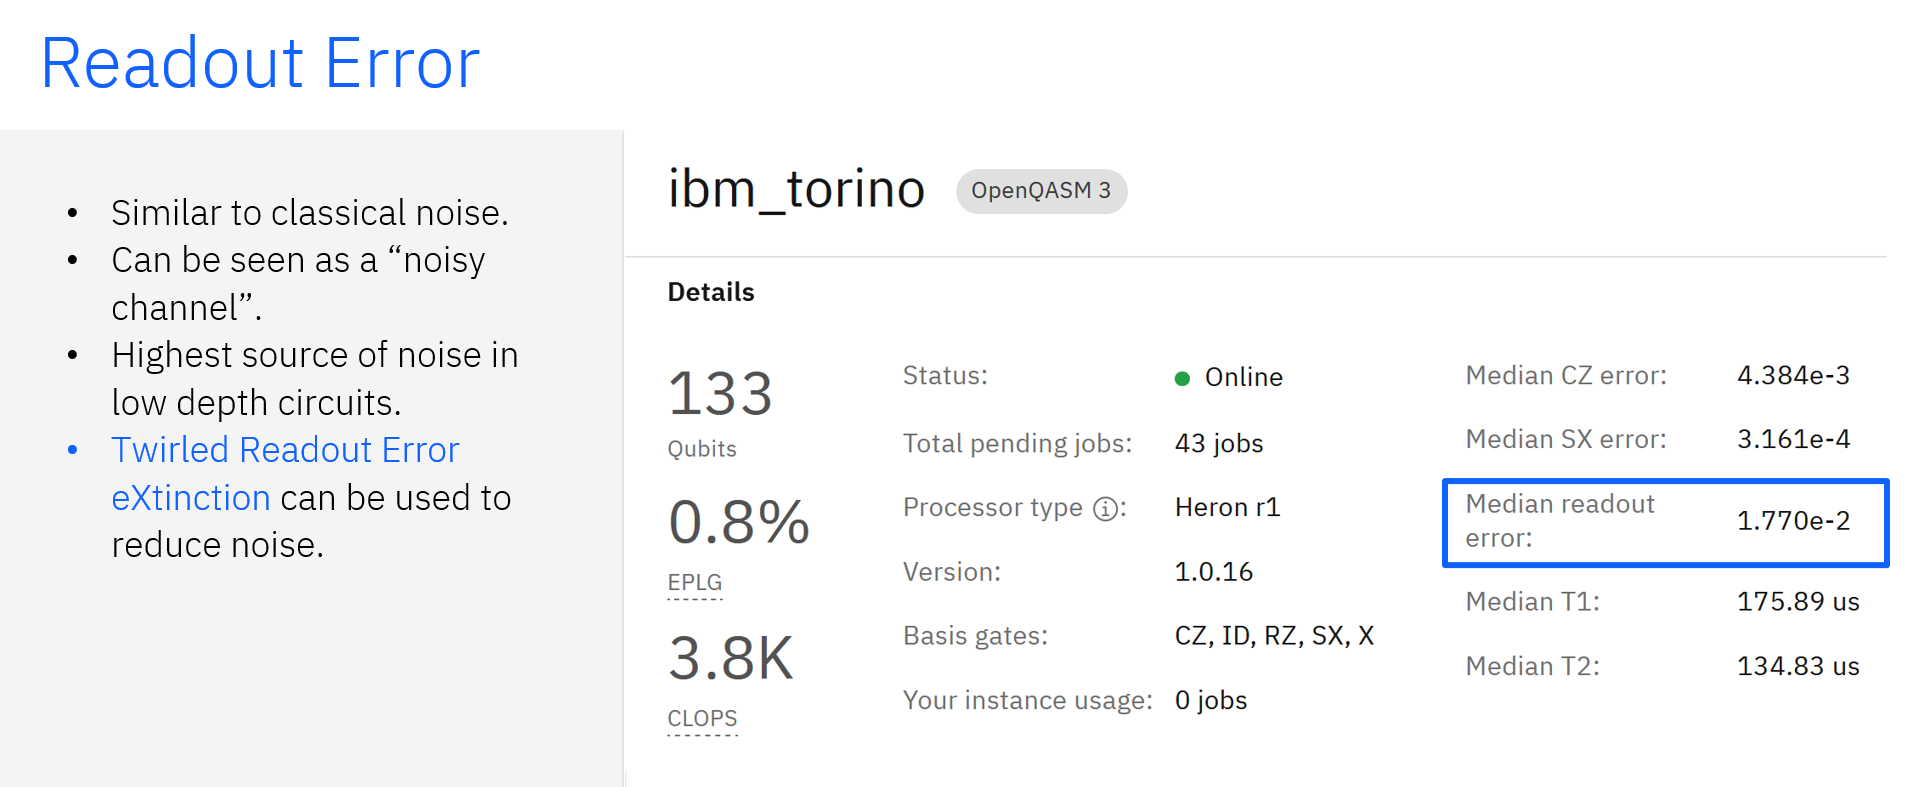

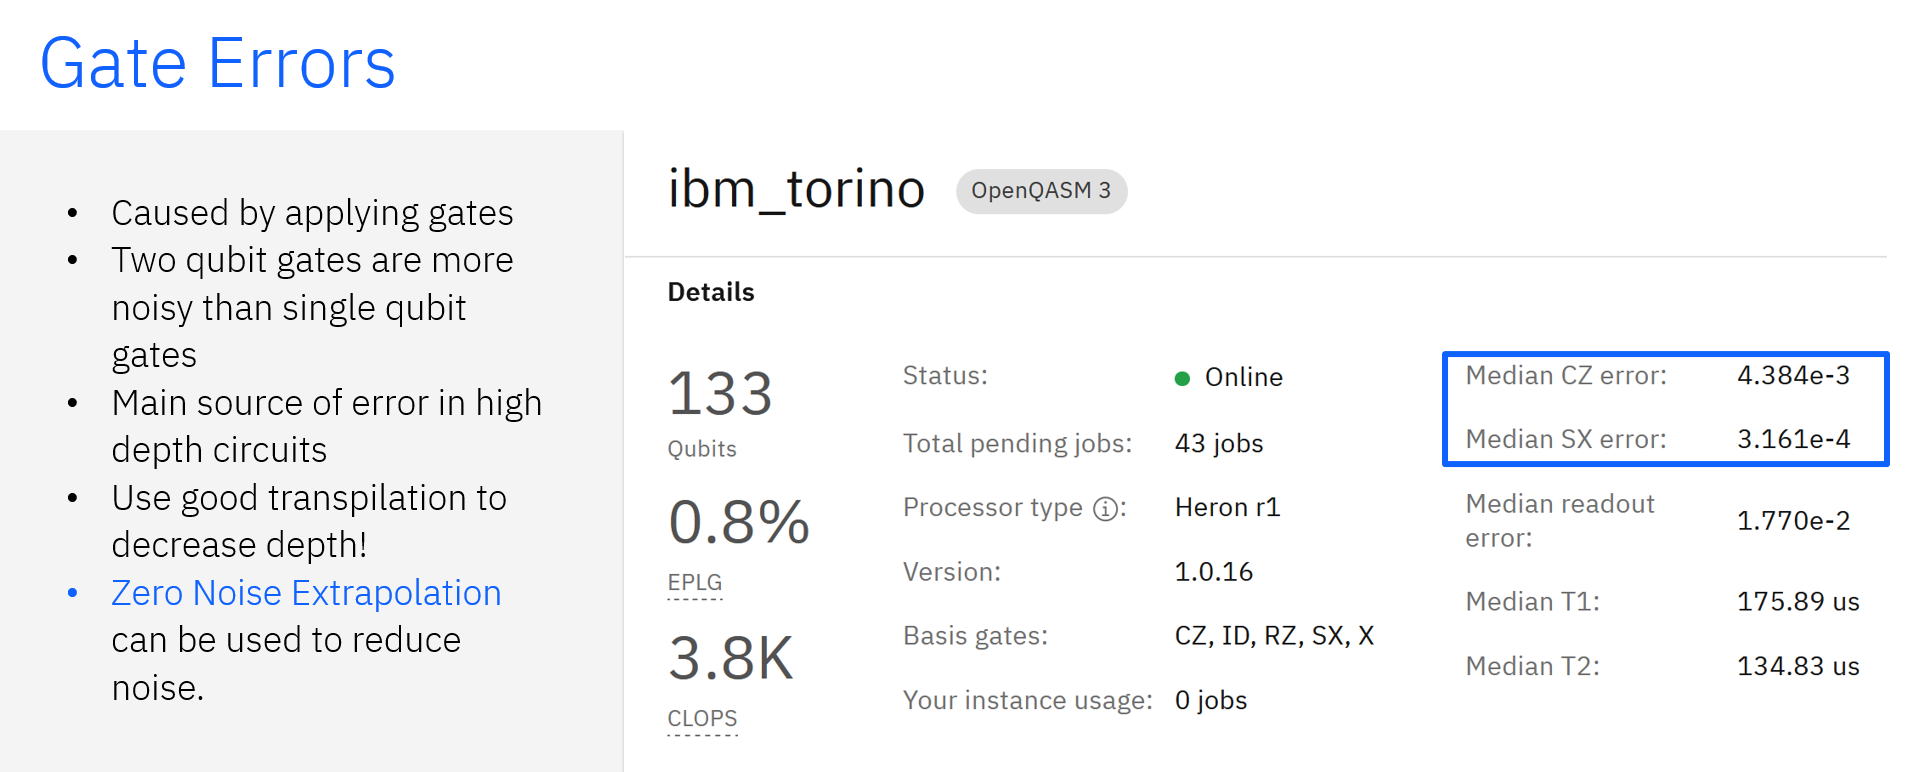

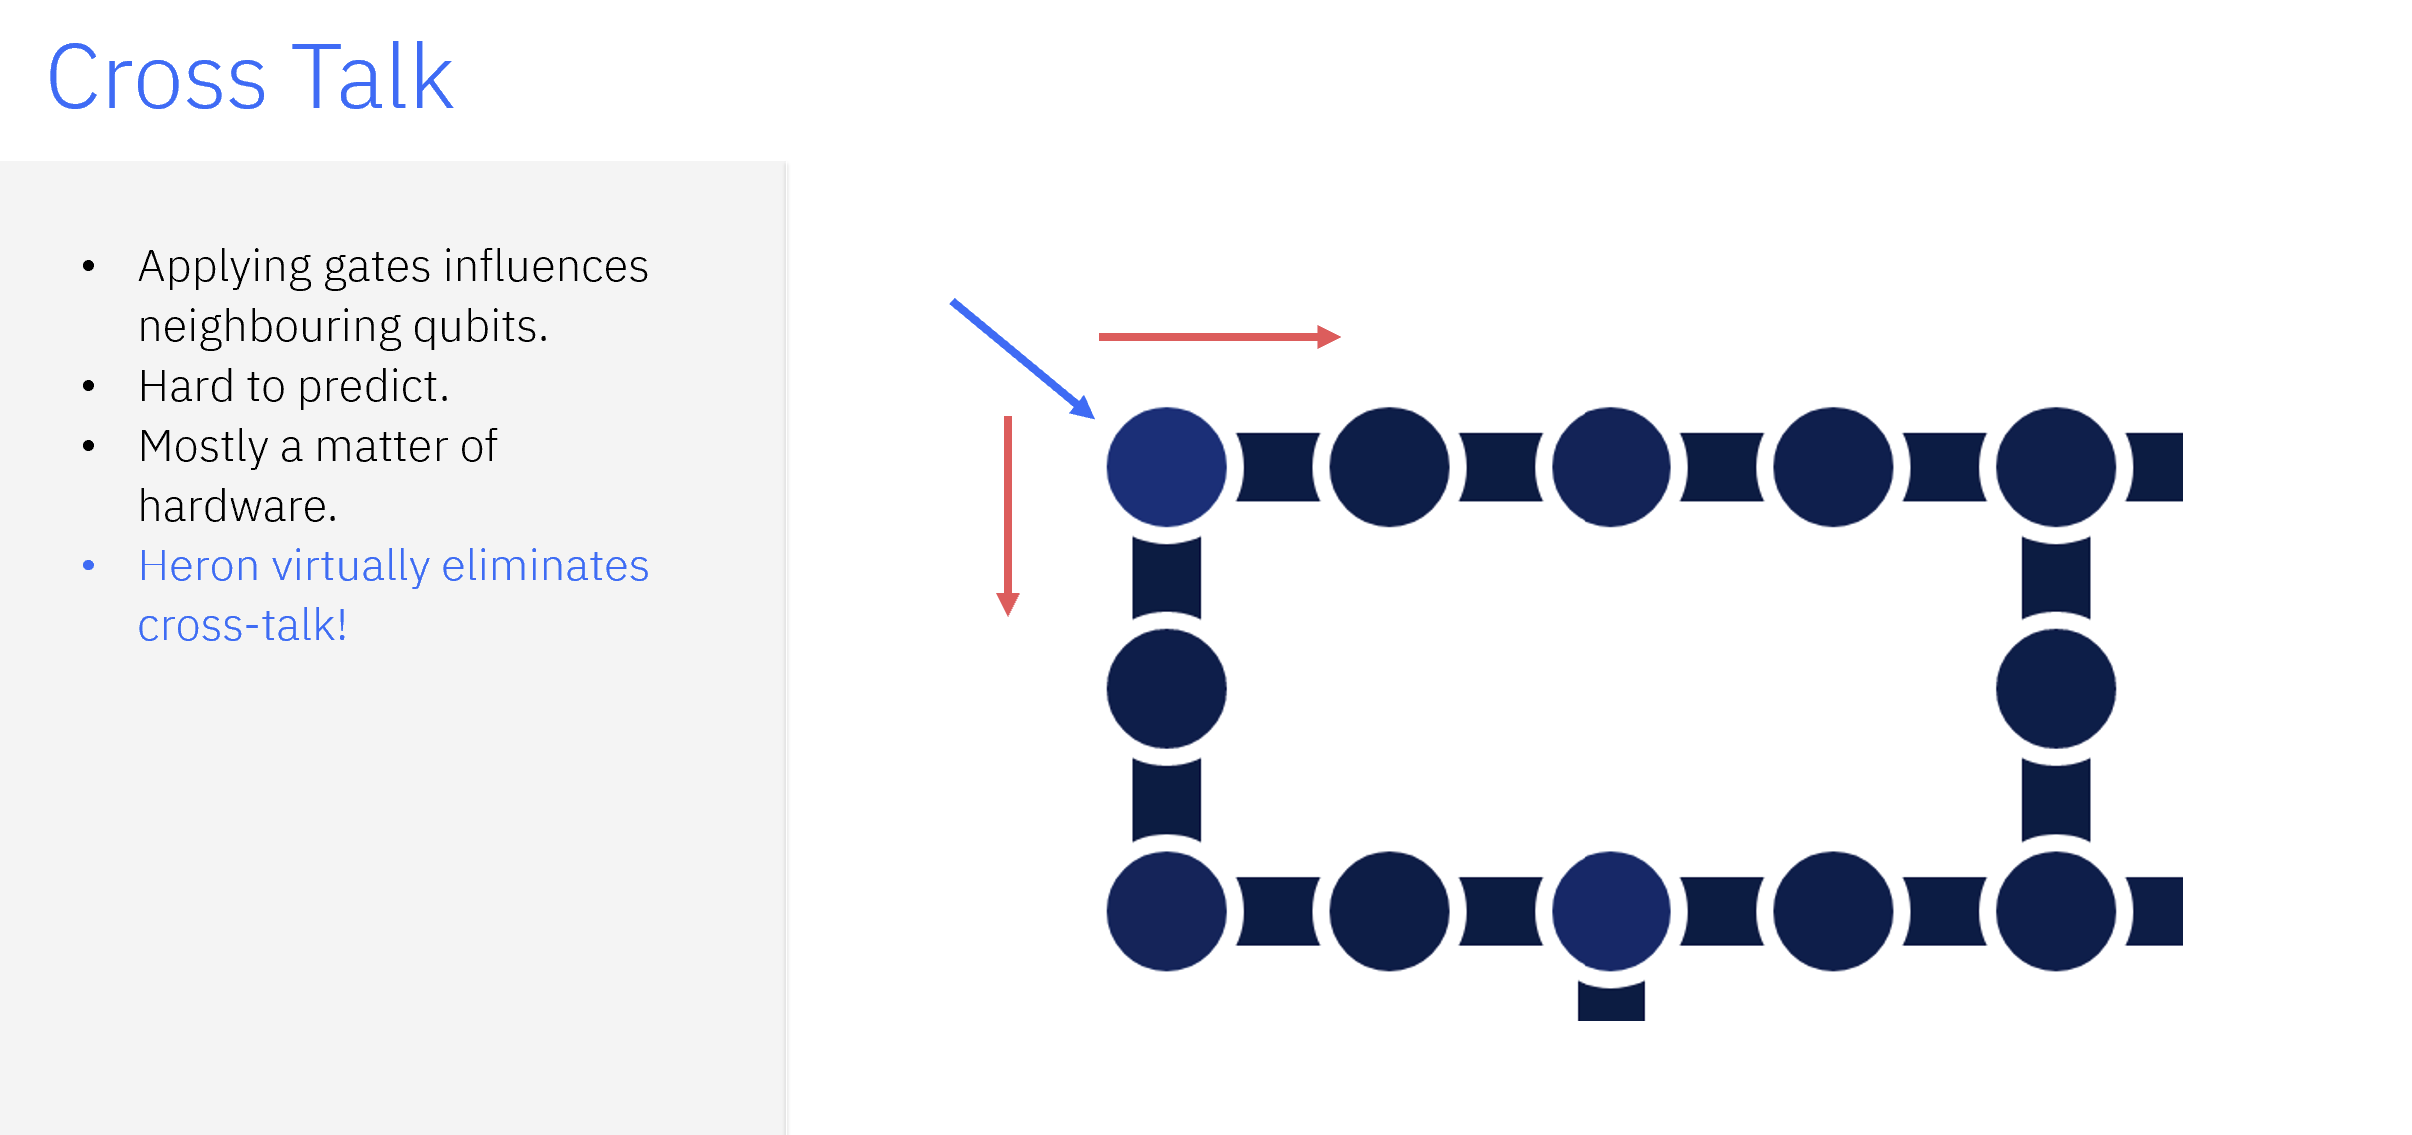

If you want to learn more about noise, this [Qiskit video](https://www.youtube.com/watch?v=3Ka11boCm1M) goes into more details.

Now that we have learned about noise, we want to make some noise, by using Qiskit to create a custom fake backend. For this, we will use the [GenericBackendV2 class](https://docs.quantum.ibm.com/api/qiskit/qiskit.providers.fake_provider.GenericBackendV2), which allows us to specify the noise levels and the connectivity of the backend we want to simulate. We assume the default all-to-all connectivity of `GenericBackendV2`.

In [ ]:
fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

Using the Generic Backend as it is not that useful, since in the end we usually want to create a fake backend that behaves as similarly as possible to a specific backend on which we want to run our quantum circuit on. In this part of the Lab, we will show you how to change the properties of the generic fake backend we have just created in a controlled manner, and thus adapt it to our needs. For this we will now create a helper function, ```update_error_rate```:

In [ ]:
def update_error_rate(backend, error_rates):

    """Updates the error rates of the backend

    Parameters: 
        backend (BackendV2): Backend to update
        error_rates (dict): Dictionary of error rates

    Returns:    
        None
    """

    default_duration=1e-8
    if "default_duration" in error_rates:
        default_duration = error_rates["default_duration"]

    # Update the 1-qubit gate properties 
    for i in range(backend.num_qubits):
        qarg = (i,)
        if "rz_error" in error_rates:
            backend.target.update_instruction_properties('rz', qarg, InstructionProperties(error=error_rates["rz_error"], duration=default_duration))
        if "x_error" in error_rates:
            backend.target.update_instruction_properties('x', qarg, InstructionProperties(error=error_rates["x_error"], duration=default_duration))
        if "sx_error" in error_rates:
            backend.target.update_instruction_properties('sx', qarg, InstructionProperties(error=error_rates["sx_error"], duration=default_duration)) 
        if "measure_error" in error_rates:
            backend.target.update_instruction_properties('measure', qarg, InstructionProperties(error=error_rates["measure_error"], duration=default_duration))            
    
    # Update the 2-qubit gate properties (CX gate) for all edges in the chosen coupling map
    if "cx_error" in error_rates:    
        for edge in backend.coupling_map:
            backend.target.update_instruction_properties('cx', tuple(edge), InstructionProperties(error=error_rates["cx_error"], duration=default_duration))

We will now use the function to change the error rate of all gates to $1e-8$, and we will also change the duration of the gates to the same number:

In [ ]:
error_rates = {
  "default_duration": 1e-8,
  "rz_error": 1e-8,
  "x_error": 1e-8,
  "sx_error": 1e-8,
  "measure_error": 1e-8,
  "cx_error": 1e-8
}

update_error_rate(fake_backend, error_rates)

<a id="exercise4"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 4:</b> 

Let's **TEST** the VQC again on the custom fake backend for different error rates and check whether we recognize the results from exercise 3.

- Whenever working with fake backends or real backends, we need to make sure we are transpiling both the circuit and the observable. You can find an example of this in the _New primitives design_ section of the recent [Qiskit SDK v1.0 blog post](https://www.ibm.com/quantum/blog/qiskit-1-0-release-summary#new-primitives-design).
- Test the VQC for different error rates for the `RZ` and `CX` gates. In each case, you will need to use the ```update_error_rate``` function. 
- Use the optimal parameters from the best run of exercise 3.
- Compute the total performance `(P)` for each error rate using the function that you created previously and plot the final cost compared to the labels of each bird.
</div>

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> This part can take around one minute!
    
</div>

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')

error_rate_list = [1e-1, 1e-2, 1e-3, 1e-4]

fake_backend = GenericBackendV2(
    num_qubits=5,
    basis_gates=["id", "rz", "sx", "x", "cx"]
  )

for error_rate_value in error_rate_list:

    ### Write your code below here ###
    error_rates = {
      "default_duration": 1e-8,
      "rz_error": error_rate_value,
      "x_error": 1e-8,
      "sx_error": 1e-8,
      "measure_error": 1e-8,
      "cx_error": error_rate_value
    }

    update_error_rate(fake_backend, error_rates)
    estimator = Estimator(backend=fake_backend)
    pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

    opt_params = res_list[best_result_index].x
    ### Don't change any code past this line ###  
    results_test = test_VQC(list_coefficients, list_labels, ansatz, obs, opt_params, estimator, pm)

    print(f"Performance for run {index}: {compute_performance(results_test, list_labels)}")
    ax.plot(results_test, 'o--', label='Predictions error rate '+str(error_rate_value))
    
ax.legend()

In [ ]:
# Submit your answer using following code
grade_lab4_ex4(fake_backend) # Expected answer type: BackendV2

## Part 3: Test the VQC on quantum hardware

In this part of the Lab, we will **TEST** our VQC on real hardware! 

To make this possible, there are a few things that need to be modified. The main problem is that the circuit which we have been considering so far (amplitude embedding + ansatz) does not take into account the limitations of the hardware. In particular, ```qc.initialize``` is a general function that allows us to map **any** statevector state into our circuit. However, this comes at the expense of efficiency. Instead, we can look at the structure of our dataset to create a tailored mapping, which should allow us to reduce the circuit depth. Moreover, so far, we have been considering the ```RealAmplitudes```ansatz with all-to-all connectivity, which leads to big number of SWAP gates after transpiling to an actual device with a heavy-hex connectivity.

To show this, we start by checking what happens when we transpile the VQC that we have been using so far for a device with limited connectivity. We are going to create a simulator from real backend data using the ```AerSimulator``` to use as our device.


<a id="tips"></a>
<div class="alert alert-block alert-info">
    
<b> Tip:</b> 

Using ```AerSimulator.from_backend(backend)``` configures the simulator automatically to mimic an IBM Quantum backend. This means implementing the current noise model of that backend, as well as the same basis gates and coupling map. Another way of obtaining a simulator that mimics an IBM Quantum backend is to use the ```qiskit_ibm_runtime.fake_provider.FakeBackend()``` object. This also automatically creates a simulator with a similar configuration, but the noise model is not the current one.

For this part of the Lab, we recommend choosing an IBM Quantum backend that you have access to, since we will use these simulations as a guide to run the code on the real backend later on. Take into account that the properties of the devices can change a lot from one to another, so testing the VQC might not work so well for certain devices. We have used [Osaka](https://quantum.ibm.com/services/resources?system=ibm_osaka).

    
</div>

In [ ]:
# Choose a real backend
service = QiskitRuntimeService()
backend = service.backend("ibm_osaka")

# Define a fake backend with the same properties as the real backend
fake_backend = AerSimulator.from_backend(backend)

Let's start by checking the two-qubit depth of circuit we get by using ```qc.initialize``` after transpilation.

In [ ]:
index_bird = 0 #you can check different birds by changing the index
qc = QuantumCircuit(num_qubits)
qc.initialize(list_coefficients[index_bird])
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", idle_wires=False, fold=40)

This circuit is too deep to be run on real quantum hardware! Let's try to find a different way to map the states of the dataset.

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 5:</b> 

Create a function to map the states more efficiently. For this we need to look closer at the data set and understand how it was built. Whenever we want to run our code on the hardware, we always need to use the structure of our data and our problem wisely!

- **IBM Quantum birds** correspond to the first 5 entries of the dictionary, with indices $0$, $1$, $2$, $3$, $4$. Their states are creating by:
    - We start by generating a GHZ state starting using the function ```generate_GHZ```.
    - Then, we change the index to its binary representation with 5 digits. For example, bird number $2$ corresponds to the binary number $00010$. This means we need to add a bit flip on the second last qubit.
    - This leads to a final GHZ state which will be $\vert 00010 \rangle + \vert 11101 \rangle$ for the bird number $2$ or $\vert 00011 \rangle + \vert 11100 \rangle$ for the bird number $3$.

- **non-IBM Quantum birds** correspond to the last 5 entries of the dictionary, with indices $5$, $6$, $7$, $8$, $9$. Here, the state is simply the product state corresponding to the binary representation of the index, as indicated in the second step above.

</div> 

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> If you create any helper functions, make sure to place them inside of the ```amplitude_embedding``` function.
    
</div>

In [ ]:
def amplitude_embedding(num_qubits, bird_index):
    """Create amplitude embedding circuit

    Parameters: 
        num_qubits (int): Number of qubits for the ansatz
        bird_index (int): Data index of the bird

    Returns:
        qc (QuantumCircuit): Quantum circuit with amplitude embedding of the bird
    """
    def generate_GHZ(qc):
        qc.h(0)
        for i, j in zip(range(num_qubits-1), range(1,num_qubits)):
            qc.cx(i, j)
            
    ### Write your code below here ###
    def generate_binary(qc, number):
        position=0
        bit=1
        while number >= bit:
            if number & bit:
                qc.x(position)
            bit <<= 1
            position=position+1

    qc = QuantumCircuit(num_qubits)
    if bird_index < 5:
        generate_GHZ(qc)
    generate_binary(qc, bird_index)
    ### Don't change any code past this line ###
    return qc

The cell below can be used to check if you are creating the correct states:

In [ ]:
index_bird = 0 # You can check different birds by changing the index

# Build the amplitude embedding 
qc = amplitude_embedding(num_qubits, index_bird)
qc.measure_all()

# Define the backend and the pass manager
aer_sim = AerSimulator()
pm = generate_preset_pass_manager(backend=aer_sim, optimization_level=3)
isa_circuit = pm.run(qc)

# Define the sampler with the number of shots
sampler = Sampler(backend=aer_sim)
result = sampler.run([isa_circuit]).result()
samp_dist = result[0].data.meas.get_counts()
plot_distribution(samp_dist, figsize=(15, 5))

Now, let's check the depth of the new amplitude embedding circuit:

In [ ]:
index_bird = 0 #You can check different birds by changing the index
qc = amplitude_embedding(num_qubits, index_bird)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_qc = pm.run(qc)

print('Depth of two-qubit gates: ', transpiled_qc.depth(lambda x: len(x.qubits) == 2))
transpiled_qc.draw(output="mpl", fold=False, idle_wires=False)

In [ ]:
# Submit your answer using following code
grade_lab4_ex5(amplitude_embedding) # Expected answer type Callable

Now, let's check the transpiled version of the ```RealAmplitudes``` ansatz using full connectivity.

In [ ]:
old_ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='full', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(old_ansatz)

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", idle_wires=False, fold=40)

<a id="exercise5"></a>
<div class="alert alert-block alert-success">
    
Change the connectivity to a _pairwise_ structure and check the depth of the circuit again. By how much was the depth reduced?

</div> 


In [ ]:
### Write your code below here ###
ansatz = RealAmplitudes(num_qubits, reps=1, entanglement='pairwise', insert_barriers=True)
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
transpiled_ansatz = pm.run(ansatz)
### Don't change any code past this line ###

print('Depth of two-qubit gates: ', transpiled_ansatz.depth(lambda x: len(x.qubits) == 2))
transpiled_ansatz.draw(output="mpl", fold=False, idle_wires=False)

Now, we can compare the total two-qubit gate depth of the old and the new VQC circuit by transpiling the composition of the amplitude embedding and the ansatz. 

In [ ]:
old_mapping = QuantumCircuit(num_qubits)
old_mapping.initialize(list_coefficients[index_bird])
old_classifier = old_mapping.compose(old_ansatz)

new_mapping = amplitude_embedding(num_qubits, index_bird)
new_classifier = new_mapping.compose(ansatz)

pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)
old_transpiled_classifier = pm.run(old_classifier)
new_transpiled_classifier = pm.run(new_classifier)

print('Old depth of two-qubit gates: ', old_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))
print('Current depth of two-qubit gates: ', new_transpiled_classifier.depth(lambda x: len(x.qubits) == 2))

With the new ansatz we have reduced the depth by a factor of 10! This means that we are ready to test our VQC on quantum hardware.

<a id="exercise6"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 6:</b> 

Create a new ```test_shallow_VQC``` function with the updated circuit. This function should implement the new amplitude embedding step and the new ansatz. Note that at this point we do not need the list of the coefficients anymore, since we are mapping each bird directly by its index.

</div> 

In [ ]:
def test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        estimator (EstimatorV2): Statevector estimator
        pm (PassManager): Pass manager for transpilation 
        
    Returns:
        results_test (list): List of test results
    """
    ### Write your code below here ###
    results_test = []
    for bird, label in enumerate(list_labels):
        qc = amplitude_embedding(num_qubits, bird)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        job = estimator.run([pub])
        result = job.result()[0].data.evs
        results_test.append(abs(result))
    ### Don't change any code past this line ###                       
    return results_test

Let's test the shallow VQC on the fake backend! We have already trained the new VQC for you, so you can use the optimal parameters given in ```opt_params_shallow_VQC.npy```. 

In [ ]:
estimator = Estimator(backend=fake_backend)
estimator.options.default_shots = 5000
pm = generate_preset_pass_manager(optimization_level=3, backend=fake_backend)

opt_params = np.load('opt_params_shallow_VQC.npy') # Load optimal parameters
results_test = test_shallow_VQC(list_labels, ansatz, obs, opt_params, estimator, pm)

print(f"Performance: {compute_performance(results_test, list_labels)}")

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')
ax.plot(list_labels, 'k-', linewidth=3, alpha=0.6, label='Labels')
ax.plot(results_test, 'o--', label='Fake Backend')
ax.legend()

In [ ]:
# Submit your answer using following code
grade_lab4_ex6(results_test) # Expected answer type: list[float]

Note that this simulation should be similar to what you would obtain on the real device that you chose before. We can see that the effect of noise lowers the performance, but we still obtain reliable results.

### TESTING ON A REAL DEVICE

In this last part of the lab, we will run the code on the actual quantum hardware.

Note that, even though the fake backend allows us to simulate the noise in our gates, it does not take into account qubit decoherence. For this particular case, we really need to address decoherence, since most of the qubits of the device are not being used for an extended period of time. This is why it is very important to use error suppression techniques such as **Dynamical Decoupling (DD)**. Moreover, we will implement different error mitigation techniques, by varying the ```resilience_level```:

- ```resilience_level = 0```: No error mitigation
- ```resilience_level = 1```: Implements **Measurement Twirling + Twirled Readout Error eXtinction (TREX)**.
- ```resilience_level = 2```: Implements `resilience_level_1` + **Zero Noise Extrapolation (ZNE) + Gate Twirling**. 

Let's explain each of these techniques in more detail:

#### Dynamical Decoupling (DD)

As we have seen in the section above, qubits can lose their information over time due to decoherence and can further be influenced by operations applied to other qubits via cross talk. These effects are especially recognizable if the qubits are already initialized in a quantum state but are not being used for an extended period during the calculation.

To eliminate these effects, we can use dynamic decoupling, which adds pulse sequences (known as dynamical decoupling sequences) to flip idle qubits around the Bloch sphere, canceling the effect of noise channels and thereby suppressing the decoherence effect.

In these 2 graphics below we can see X-gates being applied on qubits which are idle. Since we apply an even number of X-gates, the result is the identity and thus the effect of the X-gates cancel each other.


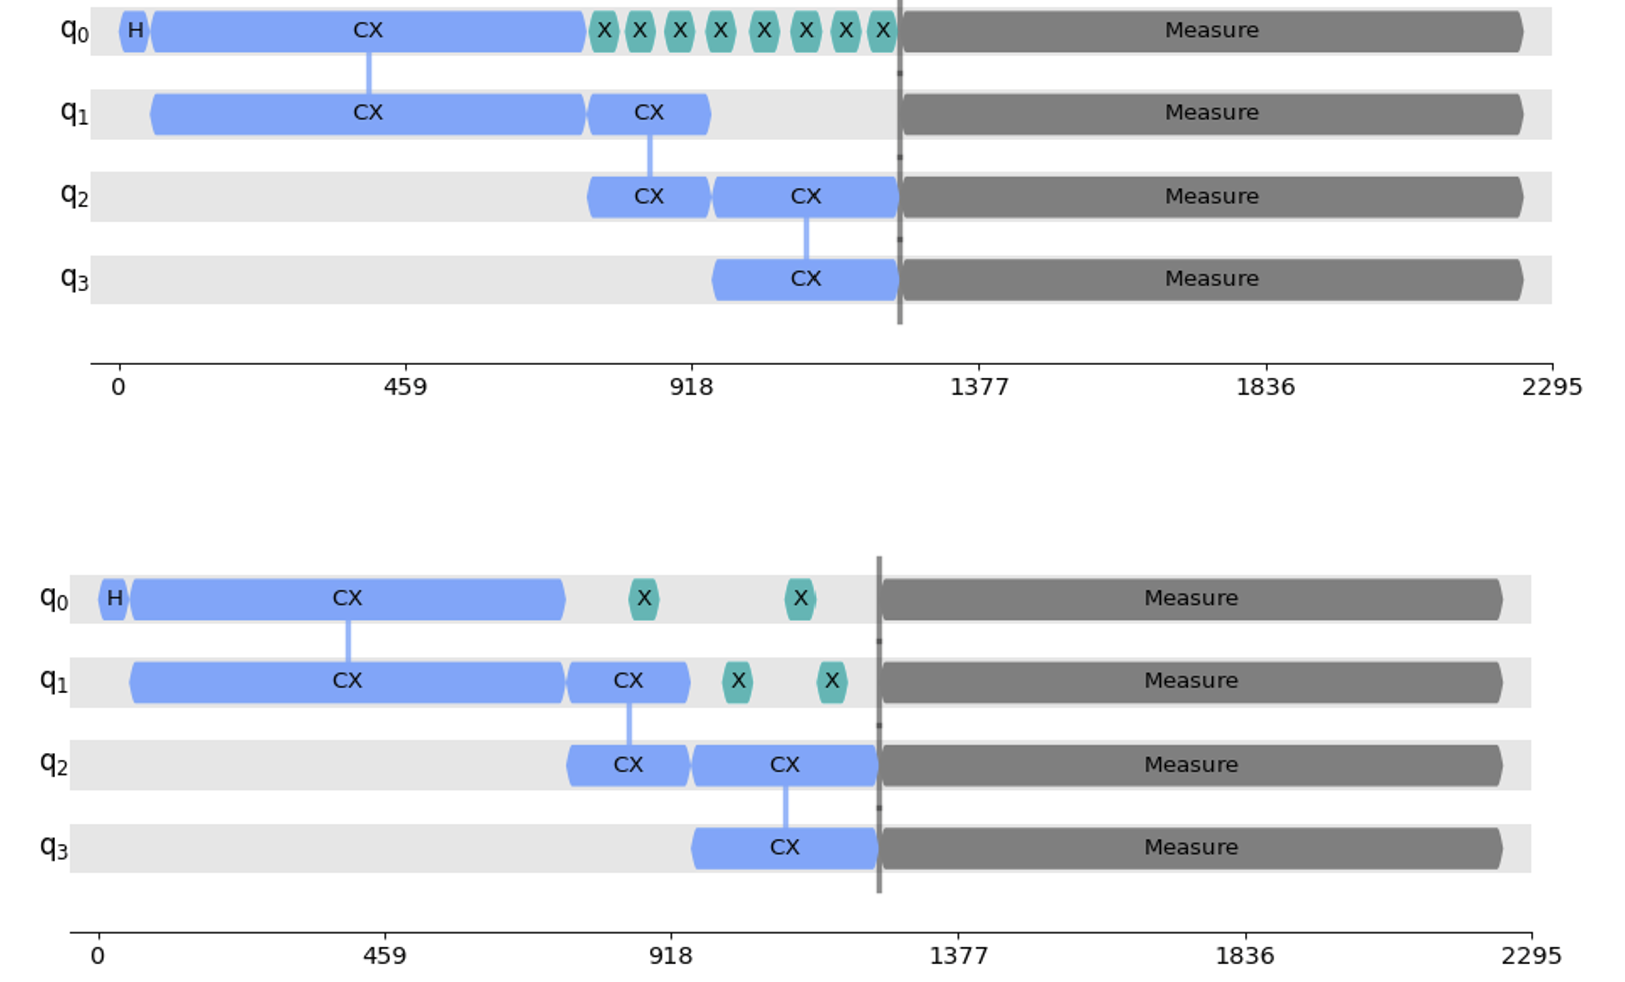


You can find more information about the dynamical decoupling [here](https://docs.quantum.ibm.com/transpile/dynamical-decoupling-pass-manager). 


#### Twirled Readout Error eXtinction (TREX)

The TREX technique reduces the measurement error by diagonalizing the noise channel associated with measurement. The channel is obtained by randomly flipping qubits through X gates immediately before measurement. A rescaling term from the diagonal noise channel is learned by benchmarking random circuits initialized in the zero state. This allows the service to remove bias from expectation values that result from readout noise. 

You can read more about this technique [here](https://arxiv.org/abs/2012.09738).

#### Zero Noise Extrapolation (ZNE)

Zero noise extrapolation is an error mitigation technique that can be used with the Estimator primitive. It has two distinct phases: 

- In the first phase, the expectation value is calculated with different noise levels by **amplifying** the noise in the circuit. 
- In the second step, the results are used to extrapolate what the expectation value would be without noise, so with zero noise. 

There are different ways to amplify the noise in the first phase. An example is gate folding, where gates in the circuit are repeated more than once. This is illustrated in the graphic below.

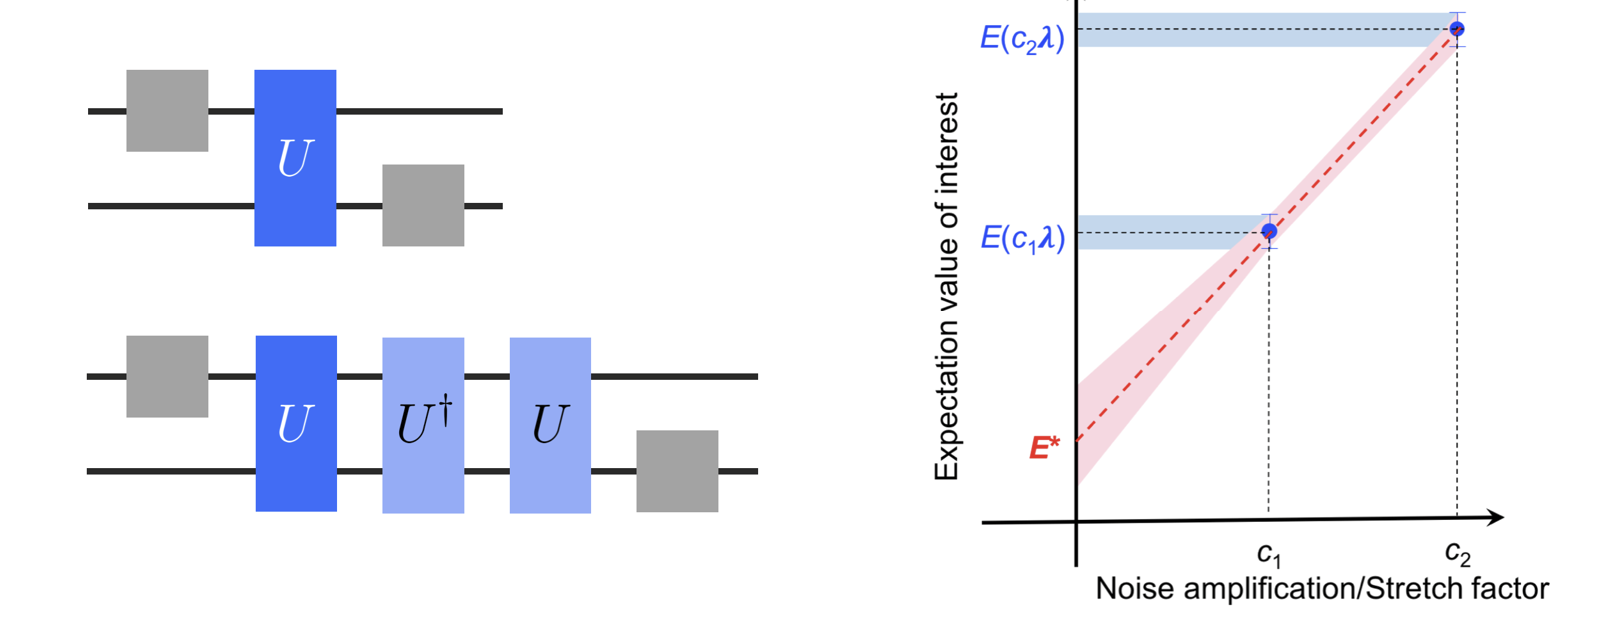

 More detais about how to configure error mitigation with for Qiskit runtime can be found in [this tutorial](https://learning.quantum.ibm.com/tutorial/combine-error-mitigation-options-with-the-estimator-primitive) as well as in [the documentation](https://docs.quantum.ibm.com/run/configure-error-mitigation).


When using the Estimator primitive, we can use the ```EstimatorOptions()``` object to set the options for error mitigation and error suppression techniques. This table shows the most used ones:

| Options              | Sub-options              | Sub-sub-options         | Choices                                                                                   | Default                   |
|----------------------|--------------------------|-------------------------|-------------------------------------------------------------------------------------------|---------------------------|
| default_shots        |                          |                         |                                                                                           | `4096`                      |
| optimization_level   |                          |                         | `0`/`1`                                                                                       | `1`                         |
| resilience_level     |                          |                         | `0`/`1`/`2`                                                                                     | `1`                         |
| dynamical_decoupling | enable                   |                         |`True`/`False`                                                                                           |`False`                           |
|                      | sequence_type            |                         | `'XX'`/`'XpXm'`/`'XY4'`                                                                         | `'XX'`                      |
|                      | extra_slack_distribution |                         | `'middle'`/`'edges'`                                                                          | `'middle'`                  |
|                      | scheduling_method        |                         | `'asap'`/`'alap'`                                                                            | `'alap'`                    |
| resilience           | measure_mitigation       |                         | `True`/`False`                                                                                | `True`                      |
|                      | measure_noise_learning   | num_randomizations      |                                                                                           | `32`                      |
|                      |                          | shots_per_randomization |                                                                                           | `'auto'`                    |
|                      | zne_mitigation           |                         | `True`/`False`                                                                                | `False`                     |
|                      | zne                      | noise_factors           |                                                                                           | `(1, 3, 5)`                 |
|                      |                          | extrapolator            | `'exponential'`/<br>`'linear'`/<br>`'double_exponential'`/<br>`'polynomial_degree_(1 <= k <= 7)'` | (`'exponential'`, `'linear'`) |
| twirling             | enable_gates             |                         | `True`/`False`                                                                                      | `False`                     |
|                      | enable_measure           |                         | `True`/`False`                                                                                      | `True`                      |
|                      | num_randomizations       |                         |                                                                                           | `'auto'`                    |
|                      | shots_per_randomization  |                         |                                                                                           | `'auto'`                    |
|                      | strategy                 |                         | `'active'`/<br>`'active-circuit'`/<br>`'active-accum'`/<br>`'all'`                                | `'active-accum'`            |

Let's start by choosing the IBM Quantum backend where we want to test our VQC:

In [ ]:
service = QiskitRuntimeService()
backend = service.backend("ibm_osaka")

<a id="exercise7"></a>
<div class="alert alert-block alert-success">
    
<b> Exercise 7:</b> 

Create a function to test the shallow VQC on the IBM Quantum backend. The function should be similar to ```test_shallow_VQC```, but now you need to create a list of pubs containing a pub for each bird ```pub = (transpiled_classifier, transpiled_obs, opt_params)```. Then, call the Estimator primitive using the list of pubs and print the job ID so that you can retrieve it later. 

Once the function is ready, you need to define the ```EstimatorOptions()``` for two different cases:

- ```options_0```: implement neither dynamical decoupling nor error mitigation techniques.
- ```options_1```: implement dynamical decoupling with sequence type `XpXm` and measurement twirling + TREX.

Set the number of shots to `5000` and ```optimization_level=0``` for both cases.
</div> 

In [ ]:
def test_shallow_VQC_QPU(list_labels, anstaz, obs, opt_params, options, backend):
    
    """Return the performance of the classifier

    Parameters:
        list_labels (list): List of labels 
        ansatz (QuantumCircuit): Parameterized ansatz circuit
        obs (SparsePauliOp): Observable
        opt_params (ndarray): Array of optimized parameters
        options (EstimatorOptions): Estimator options
        backend (service.backend): Backend to run the job 
        
    Returns:
        job_id (str): Job ID
    """

    estimator = Estimator(backend=backend, options=options)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend)

    pubs = []
    for bird, label in enumerate(list_labels):
        ### Write your code below here ###
        qc = QuantumCircuit(num_qubits)
        amplitude_embedding(qc, bird)
        classifier = qc.compose(ansatz)
        transpiled_classifier = pm.run(classifier)
        transpiled_obs = obs.apply_layout(layout=transpiled_classifier.layout)
        ### Don't change any code past this line ###
        pub = (transpiled_classifier, transpiled_obs, opt_params)
        pubs.append(pub)

    job = estimator.run(pubs)
    job_id = job.job_id()
    print(f"Job ID: {job_id}")
    print(f"Status: {job.status()}")
                                           
    return job_id

In [ ]:
## SOLUTIONS
## No DD, no TREX (no ZNE)
resilience = 0
DD = False

options_0 = EstimatorOptions(default_shots = 5000, 
                        optimization_level=0, 
                        resilience_level=resilience)  
options_0.dynamical_decoupling.enable = DD
options_0.dynamical_decoupling.sequence_type = 'XpXm'

## DD + TREX (no ZNE)
resilience = 1
DD = True
options_1 = EstimatorOptions(default_shots = 5000, 
                        optimization_level=0, 
                        resilience_level=resilience)  
options_1.dynamical_decoupling.enable = DD
options_1.dynamical_decoupling.sequence_type = 'XpXm'

In [ ]:
# Submit your answer using following code
grade_lab4_ex7(options_0, options_1) # Expected answer type: EstimatorOptions, EstimatorOptions

<a id="optional"></a>
<div class="alert alert-block alert-success">

<b> Congratulations! You have now finished the lab. </b> 

The system run is optional and ungraded. Please feel free to check out the pre-run results below or run the cells yourself to see your results.
</div>

<a id="tips"></a>
<div class="alert alert-block alert-warning">
    
<b> Warning:</b> Before running the code on the real device, make sure that everything looks correct!

Each job should take around 30 to 50 seconds on the quantum device, so even with the [Open Plan](https://www.ibm.com/quantum/pricing) _(up to 10 minutes of runtime on utility-scale systems per month)_ it should be possible to run them.
If the queue is too long, you can leave the job running and retrieve it at a later time by passing your `job_id` to the `retrieve_job` function provided below.
    
</div>

In [ ]:
def retrieve_job(job_id):

    ''' Retrieve results from job_id '''

    job = service.job(job_id)

    results_test = []
    errors_test = []
    for result in job.result():
        results_test.append(abs(result.data.evs))
        errors_test.append(abs(result.data.stds))

    return results_test, errors_test

In [ ]:
## No DD, no TREX (no ZNE)
job_id_0 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_0, backend)

## DD + TREX (no ZNE)
job_id_1 = test_shallow_VQC_QPU(list_labels, ansatz, obs, opt_params, options_1, backend)

<a id="optional"></a>
<div class="alert alert-block alert-info">
    
<b> Optional:</b> You can also try to send the job for DD + TREX + ZNE, which should yield even better results! Note that ZNE has a larger overhead, so the job will run for longer.

</div>

Once the jobs are done, you can plot the results using the following code:

In [ ]:
results_test_0_DD, errors_test_0_DD = retrieve_job() #(Add job_id 0 here)
results_test_1_DD, errors_test_1_DD = retrieve_job() #(Add job_id 1 here)

fig, ax = plt.subplots(1, 1, figsize=(7,5))
ax.set_title('Cost on test data')
ax.set_ylabel('Cost')
ax.set_xlabel('State index')

print(f"Performance for no DD + no TREX: {compute_performance(results_test_0_DD, list_labels):.3f}")
print(f"Performance for DD + TREX: {compute_performance(results_test_1_DD, list_labels):.3f}")
ax.errorbar(range(10), results_test_0_DD, fmt='-o', yerr=errors_test_0_DD, color='tab:orange', label='Osaka no EM')
ax.errorbar(range(10), results_test_1_DD, fmt='-o',  yerr=errors_test_1_DD, color='tab:blue', label='Osaka TREX + DD')

ax.plot(list_labels, 'k-', label='Labels')

ax.legend() 

Your results can vary depending on device used because the noise levels are different. This is an example of what we obtained with `ibm_kyiv`. You can see that the results improve as we implement a combination of different error mitigation and error suppression techniques.

- **Performance using no Error Mitigation:** 86.824
- **Performance using DD + TREX:** 92.979
- **Performance using DD + TREX + ZNE:** 98.004

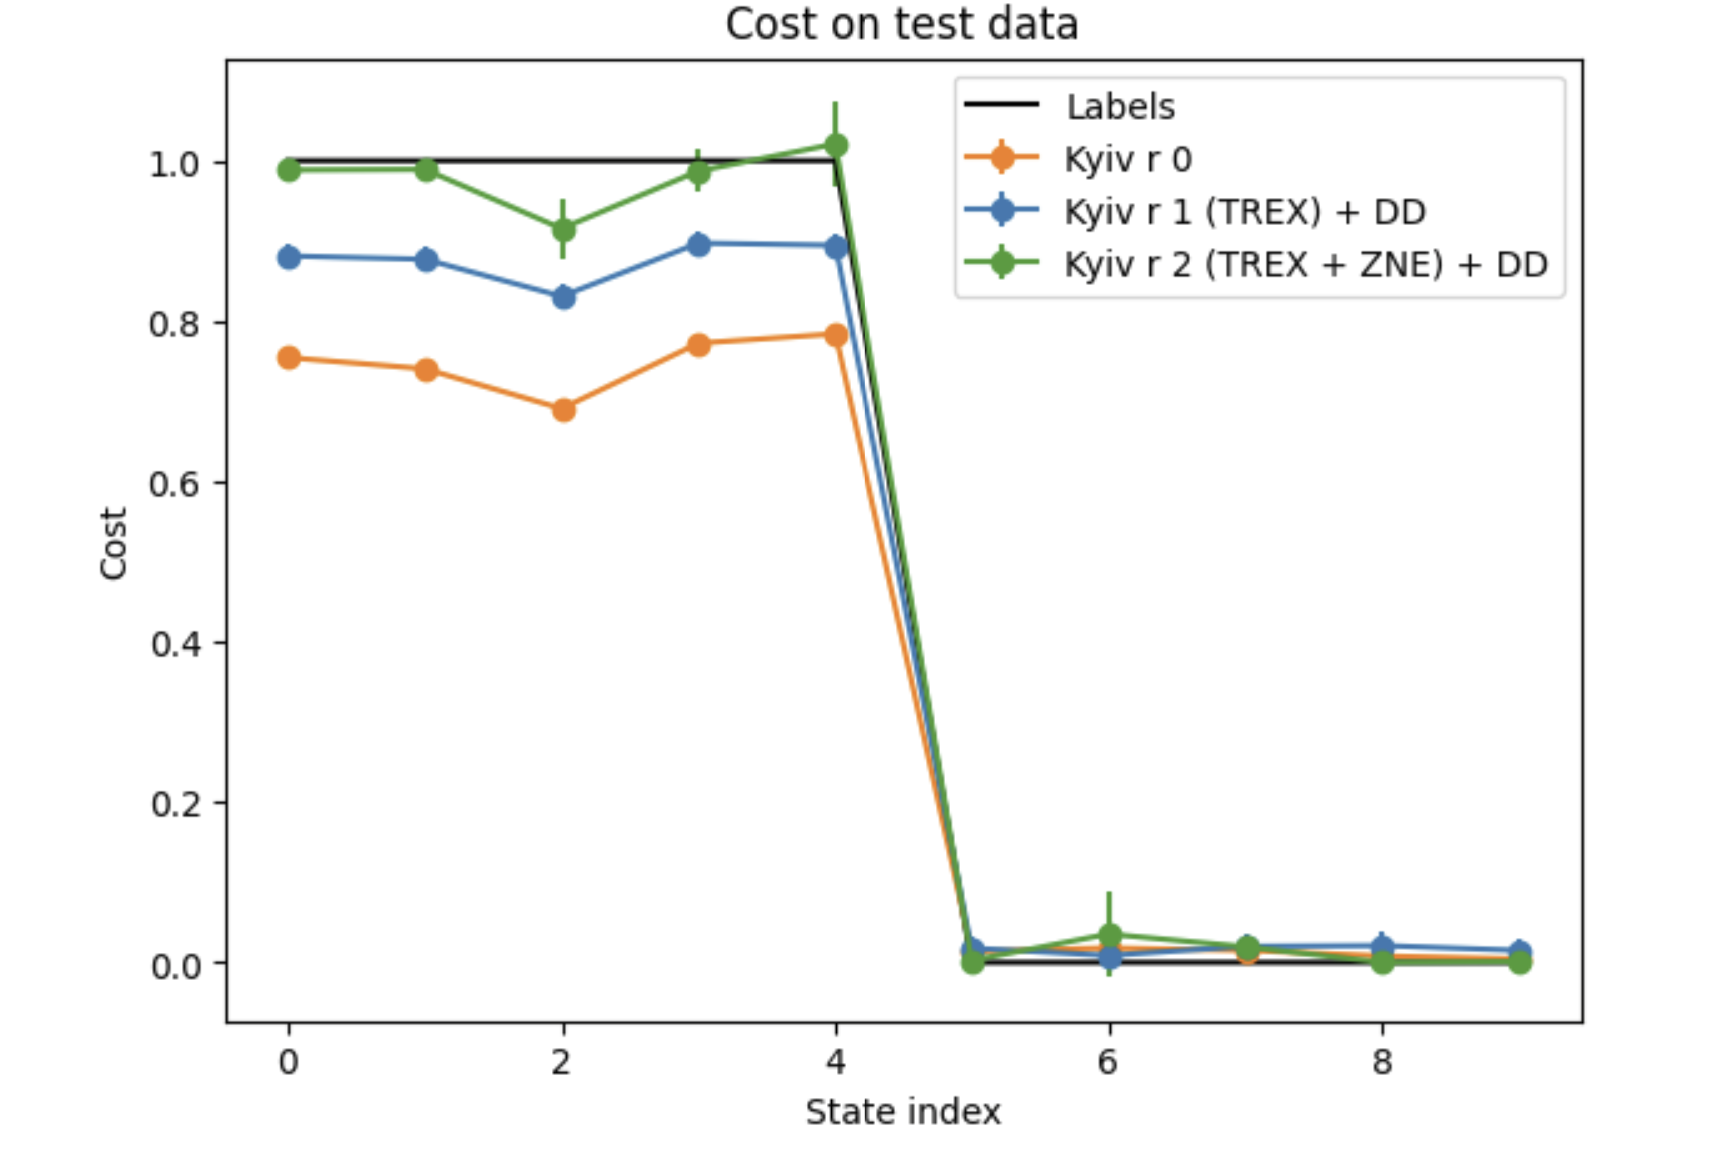

Congratulations on completing this lab on building and training a VQC using the Qiskit Patterns workflow! Throughout this exercise, you have not only gained hands-on experience in constructing and training a VQC on an ideal backend but also explored the significant impact of noise on the VQC performance.

Reducing the circuit depth and running the VQC on actual quantum hardware have provided you with a comprehensive understanding of real-world quantum computing challenges and solutions. Additionally, testing your VQC on a real backend has given you valuable insights into the practical aspects of quantum error rates and computational fidelity.

We hope this lab and the challenge has strengthened your quantum programming skills and deepened your appreciation for the intricate balance between quantum error rates and computational fidelity. Keep experimenting, learning, and pushing the boundaries of what's possible with quantum technology. The journey towards mastering quantum computing is as exciting as it is challenging, and your dedication to these exercises is a commendable step forward. 

For further learning and resources, visit the [IBM Quantum Learning platform](https://learning.quantum.ibm.com/). 

**Happy coding with Qiskit!**

# Additional information

**Created by:** Joana Fraxanet, Marcel Pfaffhauser, Junye Huang

**Advised by:** Vishal Sharathchandra Bajpe, Pedro Rivero, Blake Johnson,  Paul Nation

**Version:** 1.0.0